<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

Using MSE with min.

1. Batch data.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. Modified R2 score
5. Gene normalization

TODO:
  - Reduce the bulk into smaller.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'
# !pip -q install torcheval
# !pip -q install datasets
# path = Path('data/circadian')
path = Path('data')

In [3]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [4]:
# loss_func = F.mse_loss
def bin_mse2(inp, targ):
    # import pdb; pdb.set_trace()
    # t = torch.stack([(inp-targ)**2, (inp-targ-24)**2, (inp-targ+24)**2])
    # return torch.mean(torch.min(t, dim=0).values)
    # return torch.mean(torch.min((inp-targ)**2, (inp-targ-24)**2)) # torch.Size([128, 1])
    return torch.mean(torch.min((inp-targ)**2, torch.min((inp-targ-24)**2, (inp-targ+24)**2))) # torch.Size([128, 1])
loss_func = bin_mse2

In [5]:
class TimeLayer(nn.Module):
    def __init__(self, range = 26):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

In [6]:
from torcheval.metrics import R2Score
# metric = MetricsCB(R2Score=R2Score())
# metric = R2Score()

In [7]:
class TimeR2Score(R2Score):
    def update(self, input, target):
        inp = input.clone()
        for i, (x, y) in enumerate(zip(input, target)):
            min_x = x
            min_diff = torch.inf
            for z in [x-24, x, x+24]:
                if abs(z-y) < min_diff:
                    min_diff = abs(z-y)
                    min_x = z
            inp[i] = min_x
        super().update(inp, target)

In [8]:
metric = MetricsCB(R2Score=TimeR2Score())

## Data

In [9]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)

In [10]:
data = raw_data.set_index('gene').T
cell_sums = data.sum(axis=1)
cell_divided = data.div(cell_sums, axis=0)
nrm = (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)
data = nrm
df_mis = pd.DataFrame({f'{col}_missing':np.zeros(data.shape[0], dtype=int) for col in data.columns}, index=data.index)
data2 = data.join(df_mis)
df = data2.join(meta_data.set_index('cell_name'))
df['code'] = df.loc[:,'ZT'].str[-2:].map(float)

In [11]:
# batch_ct = pd.read_csv(batch_path/'sc_RNA_ct.csv', low_memory=False)
# batch_zt = pd.read_csv(batch_path/'sc_RNA_ZT.csv', low_memory=False)
# batch_ct.head()

In [12]:
# batch_zt.head()

In [13]:
# batch_zt

### Bulk + scRNA-seq

In [14]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [15]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [17]:
bulk_data = raw_bulk_data.set_index('ID').T
bulk_data = (bulk_data - bulk_data.mean(axis=0)) / bulk_data.std(axis=0)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [18]:
bulk_data.head()

ID,2810459M11Rik,Abcb11,Acot7,Ahctf1,Ap2a2,Asb13,Asl,Chka,Clic3,Clpx,...,Ap1s3,Vamp4,Pigm,Pard6g,Gas2,Pot1b,Zfp759,Neo1,Sco1,code
ZT2_1,1.105385,1.734929,-1.000468,-0.675204,0.840018,0.483757,-1.549016,0.124098,-0.232362,0.848045,...,2.752890,-0.473227,1.929628,0.128575,-0.790649,-0.444183,0.143286,-0.561441,-0.562906,2
ZT6_1,0.140685,0.362813,0.216831,-1.176028,-0.819429,-0.259607,-0.637751,-1.136919,-0.522711,-1.026734,...,-0.789960,0.250906,-0.690604,0.128575,0.738327,-1.036427,-1.197874,1.199442,0.094325,6
ZT10_1,-0.816706,-1.059483,0.376602,-0.640493,-1.968277,-1.844144,0.759326,-1.019758,-0.540232,-1.165550,...,0.215444,0.250906,-0.243742,-1.651693,-0.302307,-0.049354,1.828333,-1.939524,-1.767828,10
ZT14_1,-0.746059,-0.951535,1.700414,0.762807,-0.123532,-0.425885,0.793645,-0.165720,-0.294937,-0.431148,...,0.550578,1.622947,0.487485,0.959366,0.023254,-0.049354,-0.647654,1.429123,1.372273,14
ZT18_1,0.250310,-0.396195,0.361386,1.328094,0.432362,0.625583,0.991523,0.580407,0.012932,1.159798,...,-0.406949,-1.197360,0.934346,-0.108794,1.197601,0.740305,0.074509,-0.178640,0.422940,18


In [19]:
gro = raw_gro.set_index('ID').T
nascent = raw_nascent.set_index('ID').T
gro = (gro - gro.mean(axis=0)) / gro.std(axis=0)
nascent = (nascent - nascent.mean(axis=0)) / nascent.std(axis=0)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]

In [20]:
bulk_genes_set = set(raw_bulk_data['ID'])
sc_genes = raw_data['gene']

In [21]:
genes = [gene for gene in sc_genes if gene in bulk_genes_set]

In [22]:
mis_genes = [gene for gene in sc_genes if gene not in bulk_genes_set]

`df2` is the bulk data used for testing.

In [23]:
df2 = pd.DataFrame(np.zeros((12, 6000), dtype=int), columns=data2.columns)

In [24]:
for gene in genes:
    df2[gene] = bulk_data[gene].values

In [25]:
for gene in sc_genes:
    if gene not in bulk_genes_set:
        df2[f'{gene}_missing'] = 1

In [26]:
df2['code'] = bulk_data['code'].values.astype(float)

/tmp/ipykernel_11518/1075454734.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2['code'] = bulk_data['code'].values.astype(float)


In [27]:
def make_df(dataset):
    genes_set = set(dataset.columns[:-1])
    genes = [gene for gene in sc_genes if gene in genes_set]
    mis_genes = [gene for gene in sc_genes if gene not in genes_set]
    df = pd.DataFrame(np.zeros((dataset.shape[0], 6000), dtype=int), columns=data2.columns)
    for gene in genes:
        df[gene] = dataset[gene].values
    for gene in sc_genes:
        if gene not in genes_set:
            df[f'{gene}_missing'] = 1
    df['code'] = dataset['code'].values.astype(float)
    print(f'% missing: {len(mis_genes)/3000*100}%')
    return df

In [28]:
nascent_df = make_df(nascent)
gro_df = make_df(gro)
rna_df = make_df(bulk_data)

/tmp/ipykernel_11518/731159244.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%
% missing: 47.56666666666667%
% missing: 47.56666666666667%


/tmp/ipykernel_11518/731159244.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)
/tmp/ipykernel_11518/731159244.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


## Using Pytorch

In [29]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-2]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

/tmp/ipykernel_11518/3413784403.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_dep = tensor(df['code'], dtype=torch.float)


In [30]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [31]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [32]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([12794, 1]), torch.Size([3198, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [33]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 6000]), torch.Size([128, 1]))

In [34]:
def make_dl(df):
    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [35]:
nascent_dl = make_dl(nascent_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
tst_dls = {'nascent':nascent_dl, 'gro':gro_dl, 'rna':rna_dl}

Changing the metric to R2Score.

In [36]:
from torcheval.metrics import R2Score
metrics = MetricsCB(TimeR2Score=TimeR2Score())
metric_fn = TimeR2Score
# metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [37]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

Change the shape of the inputs to match the shape of targets.

In [38]:
nn.Linear(len(indep_cols), 1)(xb).shape

torch.Size([128, 1])

In [39]:
get_model()(xb).shape

torch.Size([128, 1])

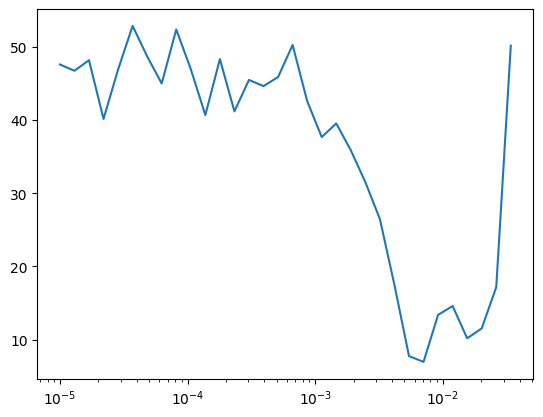

In [40]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

TimeR2Score,loss,epoch,train,time
0.844,7.308,0,True,00:01
0.965,1.646,0,False,00:00
0.980,0.922,1,True,00:01
0.969,1.424,1,False,00:00


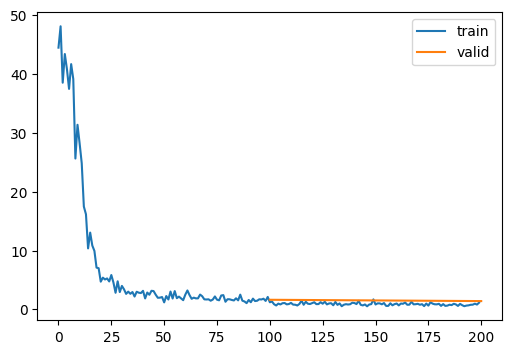

In [41]:
lr, epochs = 1e-3, 2
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [42]:
from functools import partial

In [43]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [44]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD, metric_fn=metric_fn):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = metric_fn()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        print('result: ', metric.compute())

In [45]:
nlearn = 2

Training models


TimeR2Score,loss,epoch,train,time
0.823,8.277,0,True,00:01
0.965,1.622,0,False,00:00
0.979,0.981,1,True,00:01
0.970,1.401,1,False,00:00


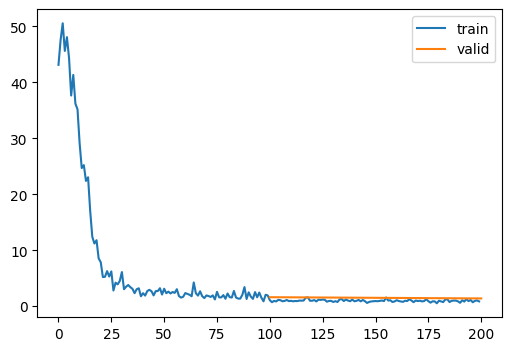

TimeR2Score,loss,epoch,train,time
0.825,8.182,0,True,00:01
0.966,1.605,0,False,00:00
0.980,0.933,1,True,00:01
0.970,1.408,1,False,00:00


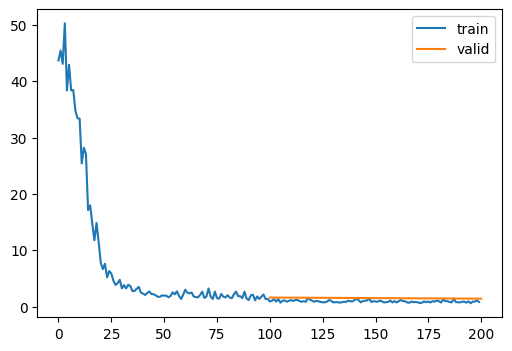

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.765,10.979,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.697,14.133,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 4.9266,  0.0000],
        [ 6.0829,  4.0000],
        [ 9.7612,  8.0000],
        [10.8239, 12.0000],
        [13.5322, 16.0000],
        [19.4193, 20.0000],
        [ 8.5519,  0.0000],
        [ 2.4624,  4.0000],
        [11.5414,  8.0000],
        [10.5285, 12.0000],
        [19.8141, 16.0000],
        [21.9535, 20.0000]])
result:  tensor(0.7356)


TimeR2Score,loss,epoch,train,time
0.590,19.370,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.713,13.543,0,False,00:00


Inference on gro
		preds, targs
tensor([[12.0365,  1.0000],
        [ 4.0987,  4.0000],
        [ 8.9467,  7.0000],
        [10.0769, 10.0000],
        [13.4686, 13.0000],
        [13.9237, 16.0000],
        [18.8319, 19.0000],
        [19.5405, 22.0000]])
result:  tensor(0.6396)


TimeR2Score,loss,epoch,train,time
0.668,15.489,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.777,10.400,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 5.1223,  2.0000],
        [ 9.6371,  6.0000],
        [ 9.2110, 10.0000],
        [12.8150, 14.0000],
        [19.3544, 18.0000],
        [20.7437, 22.0000],
        [ 6.6216,  2.0000],
        [ 9.3634,  6.0000],
        [10.9219, 10.0000],
        [12.6981, 14.0000],
        [19.1757, 18.0000],
        [12.6434, 22.0000]])
result:  tensor(0.7276)


In [46]:
ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [47]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

## Batchnorm

In [48]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

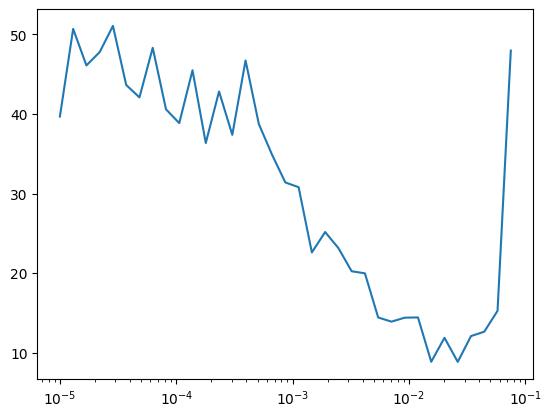

In [49]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


TimeR2Score,loss,epoch,train,time
0.840,7.485,0,True,00:01
0.884,5.394,0,False,00:00
0.886,5.329,1,True,00:01
0.913,4.057,1,False,00:00
0.926,3.486,2,True,00:01
0.938,2.867,2,False,00:00
0.951,2.302,3,True,00:01
0.950,2.333,3,False,00:00


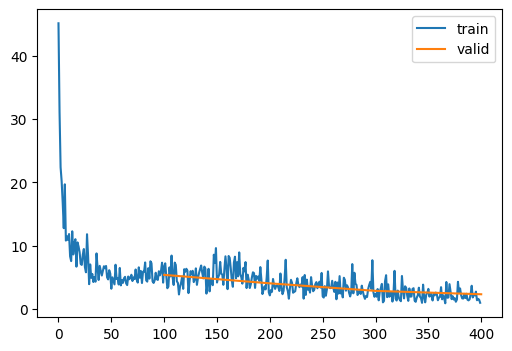

TimeR2Score,loss,epoch,train,time
0.874,5.888,0,True,00:01
0.904,4.466,0,False,00:00
0.935,3.059,1,True,00:01
0.940,2.781,1,False,00:00
0.955,2.090,2,True,00:01
0.970,1.378,2,False,00:00
0.972,1.320,3,True,00:01
0.976,1.114,3,False,00:00


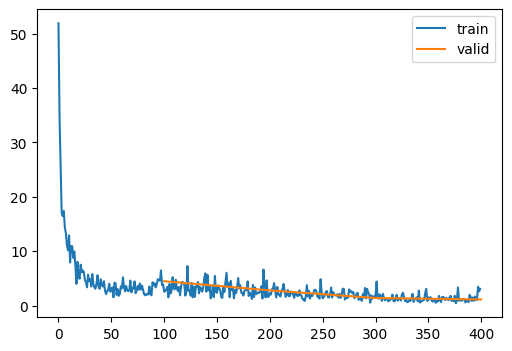

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.762,11.121,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.792,9.705,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.8983,  0.0000],
        [ 6.4384,  4.0000],
        [ 7.6869,  8.0000],
        [ 9.8609, 12.0000],
        [14.3637, 16.0000],
        [18.6489, 20.0000],
        [11.3133,  0.0000],
        [ 2.8264,  4.0000],
        [11.4726,  8.0000],
        [10.3384, 12.0000],
        [ 9.7228, 16.0000],
        [20.2609, 20.0000]])
result:  tensor(0.6300)


TimeR2Score,loss,epoch,train,time
0.640,16.996,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.943,2.703,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 1.3412,  1.0000],
        [ 4.0426,  4.0000],
        [ 7.3041,  7.0000],
        [ 9.5475, 10.0000],
        [13.7275, 13.0000],
        [ 8.9466, 16.0000],
        [18.7476, 19.0000],
        [19.5226, 22.0000]])
result:  tensor(0.8495)


TimeR2Score,loss,epoch,train,time
0.827,8.077,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.932,3.188,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 0.6612,  2.0000],
        [ 7.2490,  6.0000],
        [ 9.5867, 10.0000],
        [13.5824, 14.0000],
        [18.8922, 18.0000],
        [21.5069, 22.0000],
        [ 1.4867,  2.0000],
        [ 7.2239,  6.0000],
        [10.2807, 10.0000],
        [11.6731, 14.0000],
        [19.6004, 18.0000],
        [11.9001, 22.0000]])
result:  tensor(0.7919)


In [50]:
lr, epochs = .2, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.838,7.581,0,True,00:01
0.952,2.221,0,False,00:00
0.944,2.619,1,True,00:01
0.966,1.574,1,False,00:00
0.966,1.582,2,True,00:01
0.973,1.259,2,False,00:00
0.976,1.140,3,True,00:01
0.971,1.334,3,False,00:00


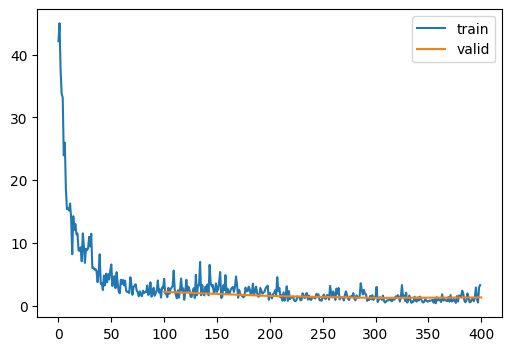

TimeR2Score,loss,epoch,train,time
0.872,6.014,0,True,00:01
0.931,3.209,0,False,00:00
0.941,2.787,1,True,00:01
0.966,1.602,1,False,00:00
0.963,1.733,2,True,00:01
0.969,1.432,2,False,00:00
0.975,1.178,3,True,00:01
0.969,1.444,3,False,00:00


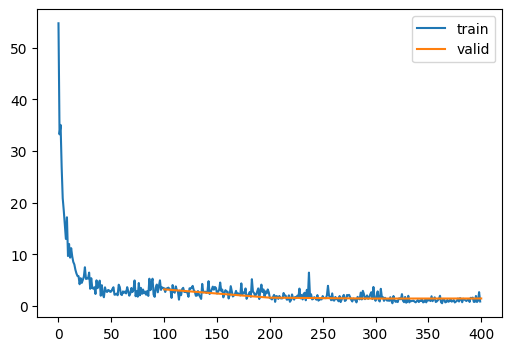

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.906,4.390,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.821,8.354,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.8827,  0.0000],
        [ 5.2564,  4.0000],
        [ 7.8100,  8.0000],
        [ 9.6326, 12.0000],
        [13.3837, 16.0000],
        [18.5689, 20.0000],
        [ 4.9810,  0.0000],
        [ 2.8064,  4.0000],
        [10.5331,  8.0000],
        [10.3531, 12.0000],
        [19.4723, 16.0000],
        [19.9810, 20.0000]])
result:  tensor(0.8717)


TimeR2Score,loss,epoch,train,time
0.673,15.461,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.823,8.351,0,False,00:00


Inference on gro
		preds, targs
tensor([[16.1813,  1.0000],
        [ 4.1428,  4.0000],
        [ 7.4066,  7.0000],
        [ 9.6253, 10.0000],
        [13.4268, 13.0000],
        [14.8253, 16.0000],
        [18.7709, 19.0000],
        [18.4089, 22.0000]])
result:  tensor(0.7550)


TimeR2Score,loss,epoch,train,time
0.773,10.609,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.940,2.799,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 2.2359,  2.0000],
        [ 6.5873,  6.0000],
        [ 9.3881, 10.0000],
        [13.6974, 14.0000],
        [18.4647, 18.0000],
        [20.6317, 22.0000],
        [ 2.8587,  2.0000],
        [ 6.7717,  6.0000],
        [ 9.9072, 10.0000],
        [10.9566, 14.0000],
        [19.5329, 18.0000],
        [14.8554, 22.0000]])
result:  tensor(0.8804)


In [51]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.885,5.376,0,True,00:01
0.922,3.651,0,False,00:00
0.915,3.978,1,True,00:01
0.933,3.119,1,False,00:00
0.942,2.740,2,True,00:01
0.961,1.827,2,False,00:00
0.965,1.627,3,True,00:02
0.972,1.298,3,False,00:00
0.974,1.238,4,True,00:01
0.975,1.166,4,False,00:00


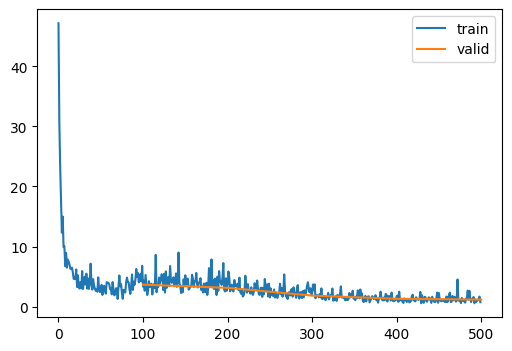

TimeR2Score,loss,epoch,train,time
0.888,5.251,0,True,00:01
0.879,5.622,0,False,00:00
0.915,3.966,1,True,00:01
0.944,2.627,1,False,00:00
0.942,2.698,2,True,00:01
0.964,1.668,2,False,00:00
0.958,1.977,3,True,00:01
0.974,1.226,3,False,00:00
0.973,1.261,4,True,00:01
0.978,1.018,4,False,00:00


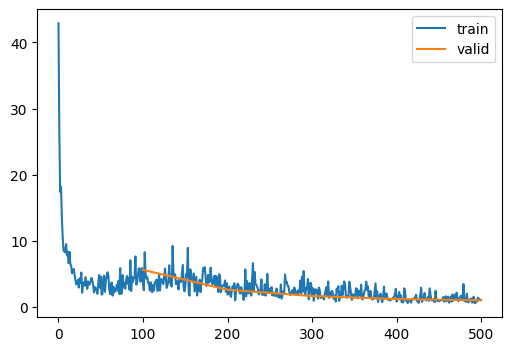

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.863,6.411,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.806,9.075,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.3202,  0.0000],
        [ 5.8947,  4.0000],
        [ 8.3374,  8.0000],
        [10.1860, 12.0000],
        [14.3151, 16.0000],
        [18.7961, 20.0000],
        [ 6.7053,  0.0000],
        [ 3.2485,  4.0000],
        [11.0132,  8.0000],
        [10.5773, 12.0000],
        [19.8070, 16.0000],
        [20.3658, 20.0000]])
result:  tensor(0.8430)


TimeR2Score,loss,epoch,train,time
0.733,12.629,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.757,11.469,0,False,00:00


Inference on gro
		preds, targs
tensor([[12.5796,  1.0000],
        [ 6.4373,  4.0000],
        [ 7.9150,  7.0000],
        [ 9.8892, 10.0000],
        [13.9261, 13.0000],
        [15.3680, 16.0000],
        [18.7497, 19.0000],
        [19.4681, 22.0000]])
result:  tensor(0.6069)


TimeR2Score,loss,epoch,train,time
0.898,4.781,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.813,8.747,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 4.4202,  2.0000],
        [ 7.4429,  6.0000],
        [ 9.6504, 10.0000],
        [14.2472, 14.0000],
        [18.1188, 18.0000],
        [20.9206, 22.0000],
        [ 5.7899,  2.0000],
        [ 7.4696,  6.0000],
        [10.3918, 10.0000],
        [11.4820, 14.0000],
        [19.3242, 18.0000],
        [16.1331, 22.0000]])
result:  tensor(0.8777)


In [52]:
lr, epochs = .3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.884,5.447,0,True,00:01
0.966,1.577,0,False,00:00
0.947,2.506,1,True,00:01
0.956,2.036,1,False,00:00
0.953,2.225,2,True,00:01
0.972,1.296,2,False,00:00
0.965,1.626,3,True,00:02
0.973,1.270,3,False,00:00
0.977,1.085,4,True,00:01
0.978,1.027,4,False,00:00


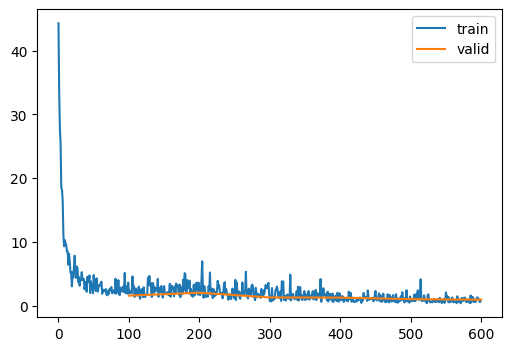

TimeR2Score,loss,epoch,train,time
0.865,6.339,0,True,00:01
0.958,1.935,0,False,00:00
0.945,2.588,1,True,00:01
0.938,2.878,1,False,00:00
0.952,2.273,2,True,00:01
0.967,1.542,2,False,00:00
0.970,1.427,3,True,00:01
0.967,1.542,3,False,00:00
0.979,1.007,4,True,00:01
0.977,1.076,4,False,00:00


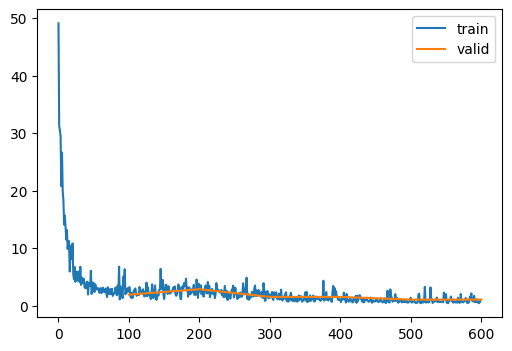

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.855,6.768,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.824,8.227,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.8079,  0.0000],
        [ 5.6361,  4.0000],
        [ 7.2576,  8.0000],
        [ 9.9867, 12.0000],
        [13.9648, 16.0000],
        [18.1903, 20.0000],
        [ 6.3617,  0.0000],
        [ 2.8273,  4.0000],
        [10.6547,  8.0000],
        [10.3587, 12.0000],
        [19.8319, 16.0000],
        [20.3225, 20.0000]])
result:  tensor(0.8411)


TimeR2Score,loss,epoch,train,time
0.966,1.591,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.863,6.456,0,False,00:00


Inference on gro
		preds, targs
tensor([[10.6826,  1.0000],
        [ 4.4481,  4.0000],
        [ 7.0314,  7.0000],
        [ 9.7871, 10.0000],
        [13.8354, 13.0000],
        [14.2169, 16.0000],
        [18.7427, 19.0000],
        [19.2390, 22.0000]])
result:  tensor(0.7207)


TimeR2Score,loss,epoch,train,time
0.813,8.744,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.871,6.020,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 1.5091,  2.0000],
        [ 6.7149,  6.0000],
        [ 9.6455, 10.0000],
        [13.6065, 14.0000],
        [18.9407, 18.0000],
        [20.2652, 22.0000],
        [ 4.7082,  2.0000],
        [ 6.8784,  6.0000],
        [10.1935, 10.0000],
        [10.9382, 14.0000],
        [19.7105, 18.0000],
        [14.3892, 22.0000]])
result:  tensor(0.8513)


In [53]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Conclusion

Unfortunately, deeper network did not perform better on bulk data than shallower network even if they did better on scRNA-seq data. Maybe because the training data is too noisy with random numbers.